# 6. PID tuning via data-driven optimization 🔩

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/06_PID_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Goals of this exercise 🌟
- We will revise some state-of-the-art data-driven optimization algorithms
- We will use data-driven optimization methods to tune the PID controller of a CSTR

## A quick reminder ✅

### Data-driven optimization

In this notebook we refer to **data-driven optimization** algorithms to the class of methods that use only function evaluations to optimize an unknown function. This is also referred to as [derivative-free](https://arxiv.org/abs/1904.11585), simulation-based, zeroth-order, and gradient-free optimization by other communities. 

Consider the optimization problem of the following form 

$$ \min_{ {\bf x} \in X} \quad  f({\bf x}) $$

The vector ${\bf x} = [x_1,..., x_n]^T$ is the optimization variable of the problem, the function $f : \mathbb{R}^n \to \mathbb{R} $ is the objective function.

Data-driven optimization algorithms assume:


*   Derivative information of $f({\bf x})$ is unavailable
*   It is only posible to sample $f$ for values of ${\bf x}$
*   $f({\bf x})$ is called a black-box function, given that we can only see the input (${\bf x}_i$) and output $(f({\bf x}_i))$, but we do not know the explict closed-form of $f$

For *expensive* (in terms of time, cost, or other metric) black-box functions, *model-based* data-driven optimization algorithms seem to offer particularly good performance. 

The **general idea** of model-based (also called *surrogate based*) algorithms is to sample the objective function and create a *surrogate* function $\hat{f}_{\mathcal{S}}$ which can be optimized easily. After optimizing $\hat{f}_{\mathcal{S}}$, the "true" objective function $f$ is sampled at the optimal location found by the surrogate. With this new datapoint, the surrogate function $\hat{f}_{\mathcal{S}}$ is refined with this new datapoint, and then optimized again. This is done iteratively until a covergence criterion is achieved.

In this specific notebook tutorial we have included 3 different state-of-the-art data-driven optimization packages, each using a different surrogate function 

*   (Py)BOBYQA
> The name BOBYQA is an acronym for **B**ound **O**ptimization **BY** **Q**uadratic **A**pproximation. BOBYQA is a type of trust-region method, and the choice of surrogate is a quadractic approximation to $f$. More details can be found in [Py-BOBYQA](https://dl.acm.org/doi/10.1145/3338517) and [BOBYQA](https://optimization-online.org/2010/05/2616/).

*   GPyOpt
> GPyOpt is a Python open-source library for Bayesian Optimization developed by the Machine Learning group of the University of Sheffield. It is based on GPy, a Python framework for Gaussian process modelling. More information can be found on their [webpage](https://sheffieldml.github.io/GPyOpt/firstexamples/index.html).

*   EntMoot
> ENTMOOT (**EN**semble **T**ree **MO**del **O**ptimization Tool) is a framework to handle tree-based surrogate models in Bayesian optimization applications. Gradient-boosted tree models from [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) are combined with a distance-based uncertainty measure in a deterministic global optimization framework to optimize black-box functions. More details on the method can be found on the [paper](https://arxiv.org/abs/2003.04774) or the [GitHub repository](https://github.com/cog-imperial/entmoot)

A comparative study can be found in: [Data-driven optimization for process systems engineering applications](https://www.sciencedirect.com/science/article/pii/S0009250921007004)

### PID controller

A proportional–integral–derivative controller ([PID controller](https://en.wikipedia.org/wiki/PID_controller)) is a control loop mechanism employing feedback that is used in industrial control systems. A PID controller calculates an error value $e(k)$ at time-step $k$ as the difference between a desired setpoint (SP) and a measured process variable (PV) and applies a correction based on proportional, integral, and derivative terms (denoted P, I, and D), hence the name. The control action is calculated as:

$$u(k)=K_P~e(k)+K_I~\sum^{i=k}_{i=0}e(i)+K_D~\frac{e(k)-e(k-1)}{\Delta t}$$

where $K_P,K_I,K_D$ are parameters to be tuned.

Traditionally, methods exist to tune such parameters, however, treating the problem as a (expensive) black-box optimization problem is an efficient solution method. 

We can formulate the discrete-time control of a chemical process by a PID controller as:

$$
\begin{aligned}
\min_{K_P,K_I,K_D} \quad & \sum_{k=0}^{k=T_f} (e(k))^2\\
\text{s.t.} \quad & x(k+1) = f(x(k),u(k)), \quad k=0,...,T_f-1 \\
& u(k)=K_P~e(k)+K_I~\sum^{i=k}_{i=0}e(i)+K_D~\frac{e(k)-e(k-1)}{\Delta t}, \quad k=0,...,T_f-1\\
& x(0)=x_0 \quad \text{given}
\end{aligned}
$$

where $e(k)=x_{SP}-x(k)$. Notice that the above optimization problem has only 3 degrees of freedom, $K_P,K_I,K_D$. Notice also that $u(k)$ is a function of $x(k)$, $u(x(k))$.

Let's first import some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy
from pylab import grid
import time

We will take the numerical precision of the machine as the epsilon tolerance for our algorithms

In [2]:
eps  = np.finfo(float).eps

## CSTR model 💻

The system used in this tutorial notebook is a Continuous Stirred Tank Reactor (CSTR) described by the following equations

$$\frac{d\text{Ca}}{dt}  = (\text{Ca}_f - \text{Ca})q/V - r_A$$

$$\frac{dT}{dt}   = \frac{q (T_f - T)}{V} + \frac{\Delta H}{(\rho ~C_p)}r_A + \frac{U_A}{(\rho~ V~  Cp)}(Tc-T)$$

with $r_A = k_0 \exp^{(-E/(RT))}\text{Ca}$.

The reaction taking place in the reactor is 

$$ A \rightarrow B $$

The reactor has a cooling jacket with temperature $T_c$ that acts as the input of the system. The states are the temperature of the reactor $T$ and the concentration $C_a$.

Details of the nomenclature for this system can be found in the code below. 

In [3]:
###############
#  CSTR model #
###############

# Taken from http://apmonitor.com/do/index.php/Main/NonlinearControl

def cstr(x,t,u):

    # ==  Inputs == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    
    # == Equations == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

In [4]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, data_simulation):    
    
    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']
    
    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

## CSTR simulation

Now let's use our CSTR model to simulate the operation under some aleatoric conditions.

First, let's define the initial conditions and create a dictionary where to store the information of the simulation 

In [5]:
data_res = {} 
# Initial conditions for the states
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

let's now define the time interval of the process and create some storing arrays for plotting

In [6]:
# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]    
Tc = np.zeros(len(t)-1);   

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T) 
data_res['Tc_dat'] = copy.deepcopy(Tc)

we will assume some noise level of the measurements

In [7]:
# noise level
noise             = 0.1
data_res['noise'] = noise

and define lower and upper bounds on the input

In [8]:
# control upper and lower bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

let's define the desired setpoints

In [9]:
# desired setpoints
n_1                = int(n/2)
n_2                = n - n_1
Ca_des             = [0.8 for i in range(n_1)] + [0.9 for i in range(n_2)]
T_des              = [330 for i in range(n_1)] + [320 for i in range(n_2)]
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

now, let's create a function that performs the simulation

In [10]:
def simulate_CSTR(u_traj, data_simulation, repetitions):
    '''
    u_traj: Trajectory of input values
    data_simulation: Dictionary of simulation data
    repetitions: Number of simulations to perform
    '''
    # loading process operations
    Ca    = copy.deepcopy(data_simulation['Ca_dat']) 
    T     = copy.deepcopy(data_simulation['T_dat']) 
    x0    = copy.deepcopy(data_simulation['x0'])
    t     = copy.deepcopy(data_simulation['t'])     
    noise = data_simulation['noise'] 
    n     = copy.deepcopy(data_simulation['n']) 
         
    # control preparation
    u_traj = np.array(u_traj)
    u_traj = u_traj.reshape(1,n-1, order='C')
    Tc    = u_traj[0,:]

    # creating lists
    Ca_dat    = np.zeros((len(t),repetitions))
    T_dat     = np.zeros((len(t),repetitions))
    Tc_dat    = np.zeros((len(t)-1,repetitions))
    u_mag_dat = np.zeros((len(t)-1,repetitions))  
    u_cha_dat = np.zeros((len(t)-2,repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        x   = x0

        # main process simulation loop
        for i in range(len(t)-1):
            ts      = [t[i],t[i+1]]
            # integrate system
            y       = odeint(cstr,x,ts,args=(Tc[i],))
            # adding stochastic behaviour 
            s       = np.random.uniform(low=-1, high=1, size=2)
            Ca[i+1] = y[-1][0] + noise*s[0]*0.1    
            T[i+1]  = y[-1][1] + noise*s[1]*5     
            # state update
            x[0] = Ca[i+1]
            x[1] = T[i+1]

        # data collection
        Ca_dat[:,rep_i]    = copy.deepcopy(Ca)
        T_dat[:,rep_i]     = copy.deepcopy(T)
        Tc_dat[:,rep_i]    = copy.deepcopy(Tc)

    return Ca_dat, T_dat, Tc_dat

The below plot shows the reactor simulated for some aleatory input. We assume
process disturbances, and therefore simulate 10 realizations and plot the 
median along with the interval for all realizations. 

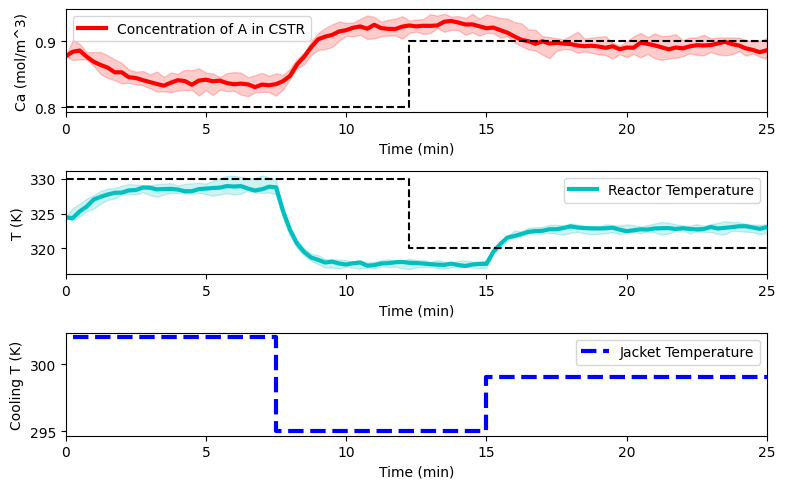

In [11]:
# Step cooling temperature to 295
u_example          = np.zeros((1,n-1))
u_example[0,:30]   = 302.0
u_example[0,30:60] = 295.0
u_example[0,60:]   = 299.0

# Simulation
Ca_dat, T_dat, Tc_dat = simulate_CSTR(u_example, data_res, 10)

# Plot the results
plot_simulation(Ca_dat, T_dat, Tc_dat, data_res)

## PID tuning of CSTR controller ➿

Now, let's use some data-driven optimization algorithms to tune the gains for the proportional-integral-derivative (PID) controllers. Here, we address the tuning of PID controllers as a black-box optimization problem.

The optimization is as follows

**PID tuning Algorithm**

*Initialization*

Collect $d$ initial datapoints $\mathcal{D}=\{(\hat{f}^{(j)}=\sum_{k=0}^{k=T_f} (e(k))^2,~K_P^{(j)},K_I^{(j)},K_D^{(j)}) \}_{j=0}^{j=d}$ by simulating $x(k+1) = f(x(\cdot),u(\cdot))$ for different values of $K_P,K_I,K_D$

*Main loop*

1. *Repeat*
2. $~~~~~~$ Build the surrogate model $\hat{f}_\mathcal{S}(K_P,K_I,K_D)$.
3. $~~~~~~$ Optimize the surrogate $K_P^*,K_I^*,K_D^* = \arg \min_{K_P,K_I,K_D} \hat{f}_\mathcal{S}(K_P,K_I,K_D)$

3. $~~~~~~$ Simulate new values  $ x(k+1) = f(x(k),u(K_P^*,K_I^*,K_D^*;x(k))), ~ k=0,...,T_f-1 $
4. $~~~~~~$ Compute $\hat{f}^{(j+1)}=\sum_{k=0}^{k=T_f} (e(k))^2$.
5. $~~~~~~$ Update: $ \mathcal{D} \leftarrow \mathcal{D}+\{(\hat{f}^{(j+1)},~K_P^*,K_I^*,K_D^*) \}$
6. until stopping criterion is met.

Remarks: 
* The initial collection of $d$ points is generally done by some space filling (e.g. [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol Sequence](https://en.wikipedia.org/wiki/Sobol_sequence)) procedure.
* Step two is generally done by some sort of least squares minimization $\min_{\hat{f}_\mathcal{S}}\sum_{j=0}^d(\hat{f}^{(j)}-\hat{f}_\mathcal{S}(K_P^{(j)},K_I^{(j)},K_D^{(j)}))^2$ 
* In Step 4 it is common not to optimize $\hat{f}_\mathcal{S}$ directly, but some adquisition function, for example, the Upper Confidence Bound in Bayesian optimization, where the mean, and some notion of the uncertainty are combined into an objective function that also explores the space. 

The example of the CSTR here is slightly more interesting, in that it has 2 state variables as set points, but the overall procedure followed is the same.


Let's create a function that computes the PID control action

In [12]:
##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u  = min(max(u,data_res['Tc_lb']),data_res['Tc_ub'])

    return u

and define the objective function as a combination of the 

*   overall error
*   magnitud of control action
*   magnitud of the control action change (from one step to another)

This is a common practice in control problems. Arguably the most important part of the objective function (assuming no constraints) is the overall error from the current point to the tracking point, denotes as the error $e(k)$. However it is generally important to consider the magnitud of the control action $|u(k)|$, this is how much "fuel" you are using, and in many cases its monetary cost is important. In most cases, it is also important not to drastically change the control action from one time-step to the other $|u(k+1)-u(k)|$, this is due to a variety of reasons, from the maintenance perspective of valves and actuators to preference on a smooth trajectory. Additionally, both penalties (magnitud and change) make the problem numerically more stable. 

Therefore, the objective function presented here is as follows

$$f =\sum_{k=0}^{k=T_f-1} w_e|e(k)| + w_u|u(k)| + w_{diff}|u(k+1)-u(k)|$$

where $w_e,w_uc,w_{diff}$ are weights that assign importance (or "adimensionalize") the different elements of the objective function.

*Remarks*: 
* We use the $\mathcal{l}_1$ norm for the objective function, but an $\mathcal{l}_2$ norm can also be used. 
* The above is for a 1-dimensional problem in the errors and the controls, but this can be generalized to multiple dimensions (by weighing each dimension accordingly), the code below shows this example.

Note that in the code below the objective function includes a simulation of the system, after which the different components of the objective function are computed. 

In [13]:
def J_ControlCSTR(Ks, data_res=data_res, collect_training_data=True, traj=False):
    
    # load data
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])    
    noise = data_res['noise']
    
    # setpoints      
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']
    
    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']

    # initiate
    x         = x0
    e_history = []

    # Simulate CSTR with PID controller
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])
        # compute control
        if i == 0:
            Tc[i] = PID(Ks, x, x_sp, np.array([[0,0]]))
        else:
            Tc[i] = PID(Ks, x, x_sp, np.array(e_history))
        # simulate system
        y         = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s       = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1] = y[-1][0] + noise*s[0]*0.1    
        T[i+1]  = y[-1][1] + noise*s[1]*5     
        # state update
        x[0] = Ca[i+1]
        x[1] = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)
        data_res['Ks'].append(Ks)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha

In order to pick intial starting points we create below a random search function

In [14]:
#########################
# --- Random search --- #
#########################

# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float 
def Random_search(f, n_p, bounds_rs, iter_rs):
    '''
    This function is a naive optimization routine that randomly samples the 
    allowed space and returns the best value.

    This is used to find a good starting point
    '''

    # arrays to store sampled points
    localx   = np.zeros((n_p,iter_rs))  # points sampled
    localval = np.zeros((iter_rs))        # function values sampled
    # bounds
    bounds_range = bounds_rs[:,1] - bounds_rs[:,0]
    bounds_bias  = bounds_rs[:,0]

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(0, 1, n_p)*bounds_range + bounds_bias # sampling
        localx[:,sample_i] = x_trial
        localval[sample_i] = f(x_trial) # f
    # choosing the best
    minindex = np.argmin(localval)
    f_b      = localval[minindex]
    x_b      = localx[:,minindex]

    return f_b,x_b

### BOBYQA - Bound Optimization by Quadratic Approximation



In [15]:
if 'google.colab' in str(get_ipython()):
    !pip install Py-BOBYQA
import pybobyqa

In [16]:
def opt_PyBOBYQA(f, x_dim, bounds, iter_tot):
    '''
    More info:
    https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/userguide.html#a-simple-example
    '''

    # iterations to find good starting point
    n_rs = 3

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs)
    iter_          = iter_tot - n_rs

    # restructure bounds
    a = bounds[:,0]; b = bounds[:,1]
    pybobyqa_bounds    = (a,b)
    other_outputs      = {}

    soln = pybobyqa.solve(f, x_best, seek_global_minimum=True, 
                          objfun_has_noise=True,
                          user_params = {'restarts.use_restarts':True,
                                         'logging.save_diagnostic_info': True,
                                         'logging.save_xk': True}, 
                          maxfun=iter_, 
                          bounds=pybobyqa_bounds, 
                          rhobeg=0.1)
    
    other_outputs['soln']  = soln
    other_outputs['x_all'] = np.array(soln.diagnostic_info['xk'].tolist())

    return soln.x, f(soln.x), other_outputs

Notice that it is not immidiately clear what the bounds on $K_P,K_I,K_D$ should be, and these are generally set as a comnbination of intuition, prior knowledge, and trial and error. 

this optimization took  1.8473377227783203  (s)


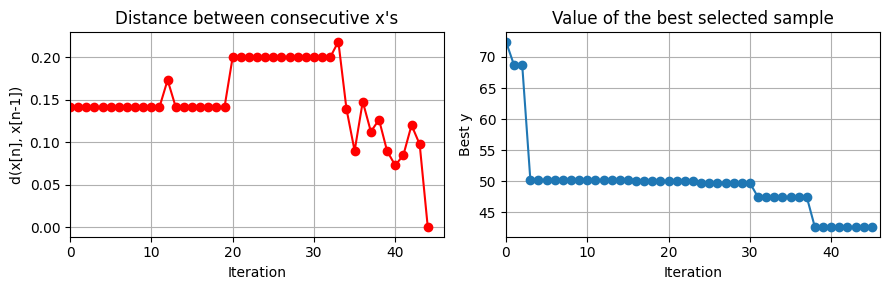

In [17]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])

# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
Kbobyqa, f_opt, other_outputs = opt_PyBOBYQA(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

plot_convergence(np.array(data_res['Ks'])[5:], None, J_ControlCSTR)


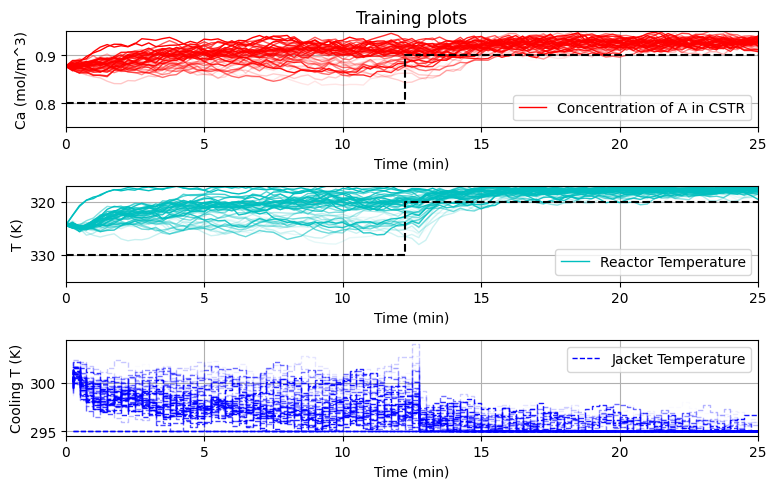

In [18]:
plot_training(data_res,iter_tot)

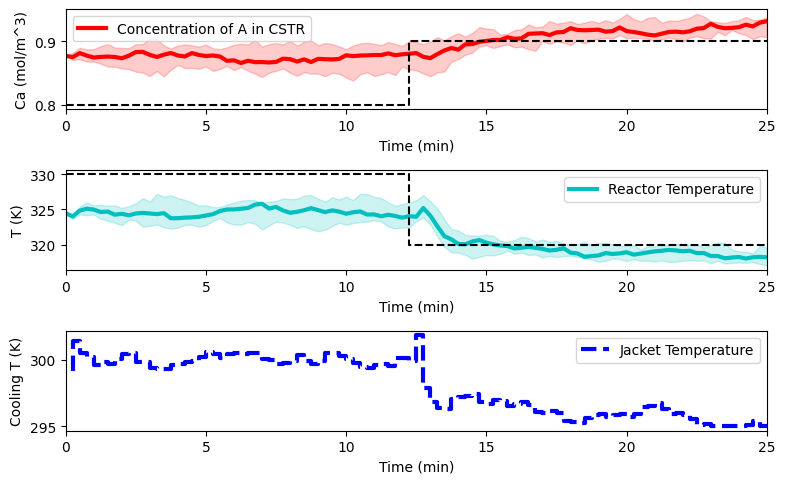

In [19]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(Kbobyqa, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

### BO - Bayesian Optimization

In [20]:
if 'google.colab' in str(get_ipython()):
    !pip install gpyopt

import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [21]:
def opt_GPyOpt(f, x_dim, bounds, iter_tot):
    '''
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    '''

    bounds_GPyOpt = [{'name':'var_'+str(i+1),
                    'type': 'continuous',
                    'domain': (bounds[i,0],bounds[i,1])}
                    for i in range(len(bounds))]

    myBopt = GPyOpt.methods.BayesianOptimization(f, domain=bounds_GPyOpt)
    myBopt.run_optimization(max_iter = iter_tot)

    return myBopt.x_opt, myBopt.fx_opt, myBopt

this optimization took  30.6100492477417  (s)


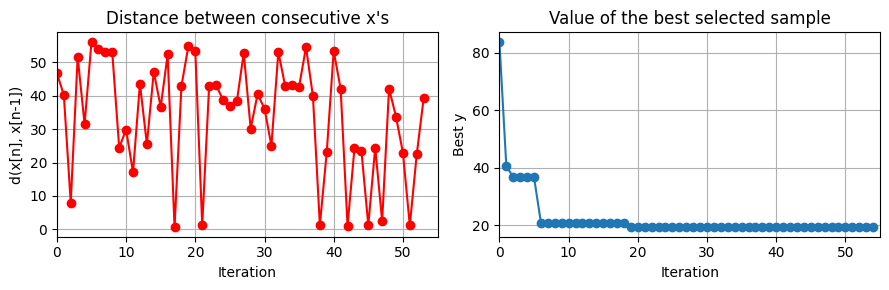

In [22]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])
# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
KBOpt, f_opt, other_outputs = opt_GPyOpt(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

evals = np.array(data_res['Ks']).shape[0]
plot_convergence(np.array(data_res['Ks']).reshape(evals,7), None, J_ControlCSTR)

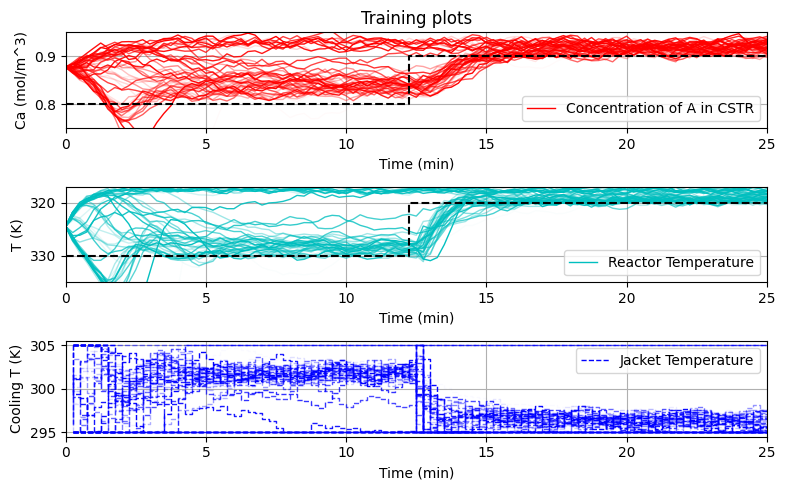

In [23]:
plot_training(data_res, iter_tot)

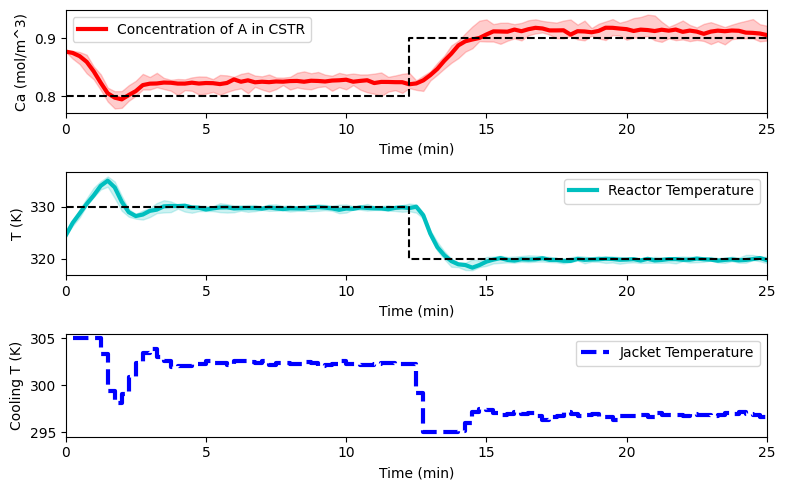

In [24]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(KBOpt, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

### EntMooT - Ensemble Tree Model Optimization

In [25]:
if 'google.colab' in str(get_ipython()):
    !pip install gurobipy
    !pip install git+https://github.com/cog-imperial/entmoot

from entmoot.optimizer.optimizer import Optimizer

In [26]:
def opt_ENTMOOT(f, x_dim, bounds, iter_tot):
    '''
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    '''
    
    opt = Optimizer(bounds,
                    base_estimator="ENTING",
                    n_initial_points=int(iter_tot*.2),
                    initial_point_generator="random",
                    acq_func="LCB",
                    acq_optimizer="sampling",
                    random_state=100,
                    model_queue_size=None,
                    base_estimator_kwargs={
                        "lgbm_params": {"min_child_samples": 1}
                    },
                    verbose=False,
                    )

    # run optimizer for 20 iterations
    res = opt.run(f, n_iter=iter_tot)

    return res.x, res.fun, res

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 5/50 [00:00<00:01, 42.76it/s]

 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 41.11it/s]

 30%|████████████████████████▌                                                         | 15/50 [00:03<00:11,  3.16it/s]

 36%|█████████████████████████████▌                                                    | 18/50 [00:05<00:13,  2.38it/s]

 40%|████████████████████████████████▊                                                 | 20/50 [00:06<00:14,  2.10it/s]

 42%|██████████████████████████████████▍                                               | 21/50 [00:07<00:14,  1.99it/s]

 44%|████████████████████████████████████                                              | 22/50 [00:08<00:14,  1.87it/s]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:09<00:15,  1.73it/s]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:09<00:15,  1.65it/s]

 50%|█████████████████████████████████████████                                         | 25/50 [00:10<00:16,  1.49it/s]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:11<00:17,  1.40it/s]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:12<00:16,  1.37it/s]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:13<00:15,  1.38it/s]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:13<00:15,  1.37it/s]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:14<00:14,  1.37it/s]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:15<00:13,  1.36it/s]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:16<00:13,  1.34it/s]

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:16<00:12,  1.31it/s]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:17<00:12,  1.33it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:18<00:11,  1.34it/s]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:19<00:10,  1.33it/s]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:19<00:09,  1.33it/s]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:20<00:09,  1.33it/s]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:21<00:08,  1.33it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:22<00:07,  1.33it/s]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:22<00:06,  1.33it/s]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:23<00:06,  1.30it/s]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:24<00:05,  1.30it/s]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:25<00:04,  1.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:25<00:03,  1.29it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:26<00:03,  1.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:27<00:02,  1.23it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:28<00:01,  1.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:29<00:00,  1.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]

this optimization took  30.297902822494507  (s)


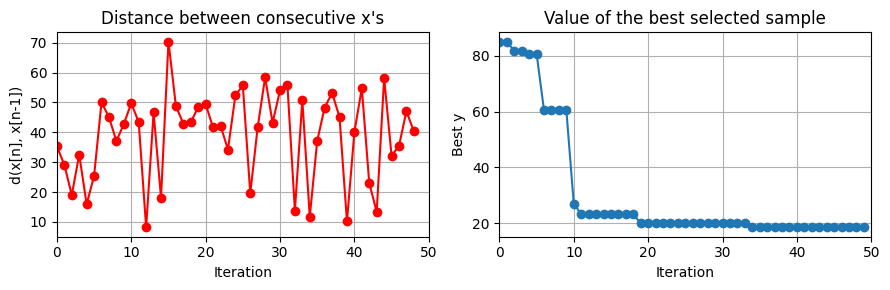

In [27]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])
# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
KentMoot, f_opt, other_outputs = opt_ENTMOOT(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

#evals = np.array(data_res['Ks']).shape[0]
plot_convergence(np.array(data_res['Ks']), None, J_ControlCSTR)

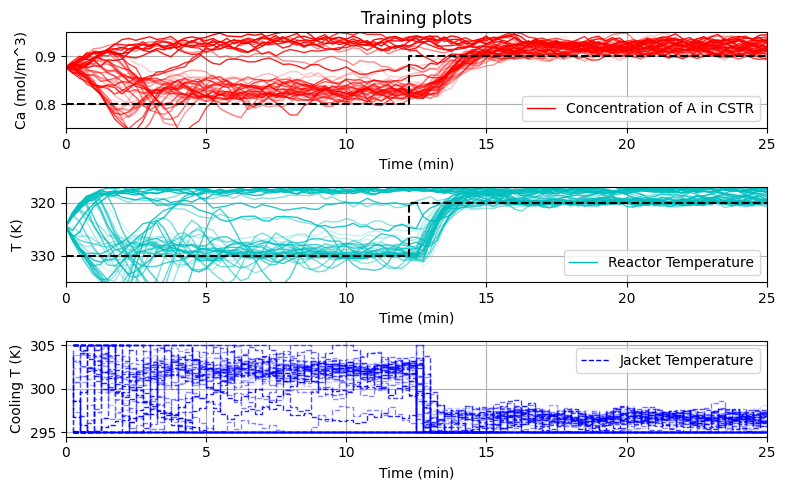

In [28]:
plot_training(data_res,iter_tot)

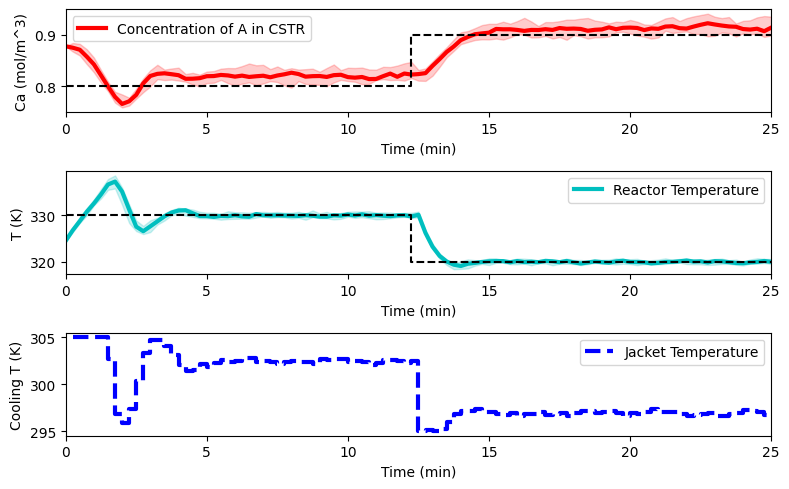

In [29]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(KentMoot, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Final remarks

This notebook presents three different data-driven optimization methods for PID tuning. We suggest that you try out these methods in your own problems to get a feel for them. 

Some rules of thumb (which can be easily disproven) are as follows: BOBYQA is faster than EntMooT which is faster than Bayesian optimization. However, if the samples allowed is low, say lower than 50 (either because of computational, time, or monetary limitations), Bayesian optimization is likely to perform the best, followed by EntMooT, followed by BOBYQA. As the number of possible evaluations increase, this order is reversed.

All three algortihms presented here have many hyperparameters (have a look at their documentation!) and can be extremely efficient if used with enough knowledge and practice.